In [1]:
# If you want to run this on Google Colab, just uncomment the following lines. Please note,
# that you will need to locate your folder directly in the root directory of your Google Drive (/content/drive/My Drive/).
# Because otherwise, it won't work out of the box and you would need to adjust the path in here.
#
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#
#import os
#os.chdir("/content/drive/My Drive/CSMP-Project")

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from keras import layers

In [3]:
data_file = '../../../data/oldNorm.csv'

dataset = pd.read_csv(data_file, sep=';')
dataset = dataset.drop(dataset[dataset['normPullOff'] > 2e-3].index) #* 1_000_000

dataset

,size,lambdaR,lambdaS,gamma,rho,normPullOff
1,1536,128,64,0.435573,1.676090,0.000039
2,1536,512,16,0.005227,3.182120,0.000133
4,2048,256,16,0.076352,2.988800,0.000205
5,512,64,64,0.078444,0.914735,0.000155
6,1536,384,24,0.148421,2.714410,0.000189
...,...,...,...,...,...,...
291,1536,1536,32,0.194987,3.891570,0.000609
293,768,768,96,0.727092,4.590560,0.001356
294,1280,640,16,0.859444,4.347240,0.000921
296,1536,256,256,0.448628,0.302274,0.000016


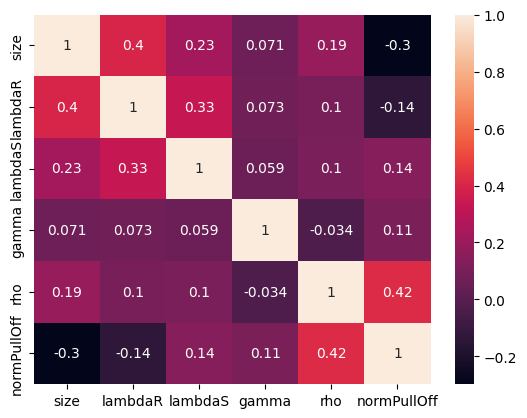

In [4]:
dataplot = sns.heatmap(dataset.corr(), cmap="rocket", annot=True)

plt.show()

In [5]:
dataset.describe()

,size,lambdaR,lambdaS,gamma,rho,normPullOff
count,204.000000,204.000000,204.000000,204.000000,204.000000,2.040000e+02
mean,1385.411765,624.313725,108.078431,0.484631,2.237625,4.735787e-04
std,464.877596,569.752569,228.072052,0.291753,1.406656,4.698831e-04
min,256.000000,32.000000,4.000000,0.005227,0.014722,2.130000e-09
25%,1024.000000,192.000000,16.000000,0.214020,1.047165,9.430000e-05
50%,1536.000000,384.000000,40.000000,0.478776,2.142950,3.036165e-04
75%,1792.000000,896.000000,128.000000,0.728510,3.277508,6.994865e-04
max,2048.000000,2048.000000,2048.000000,0.995214,4.975850,1.921510e-03


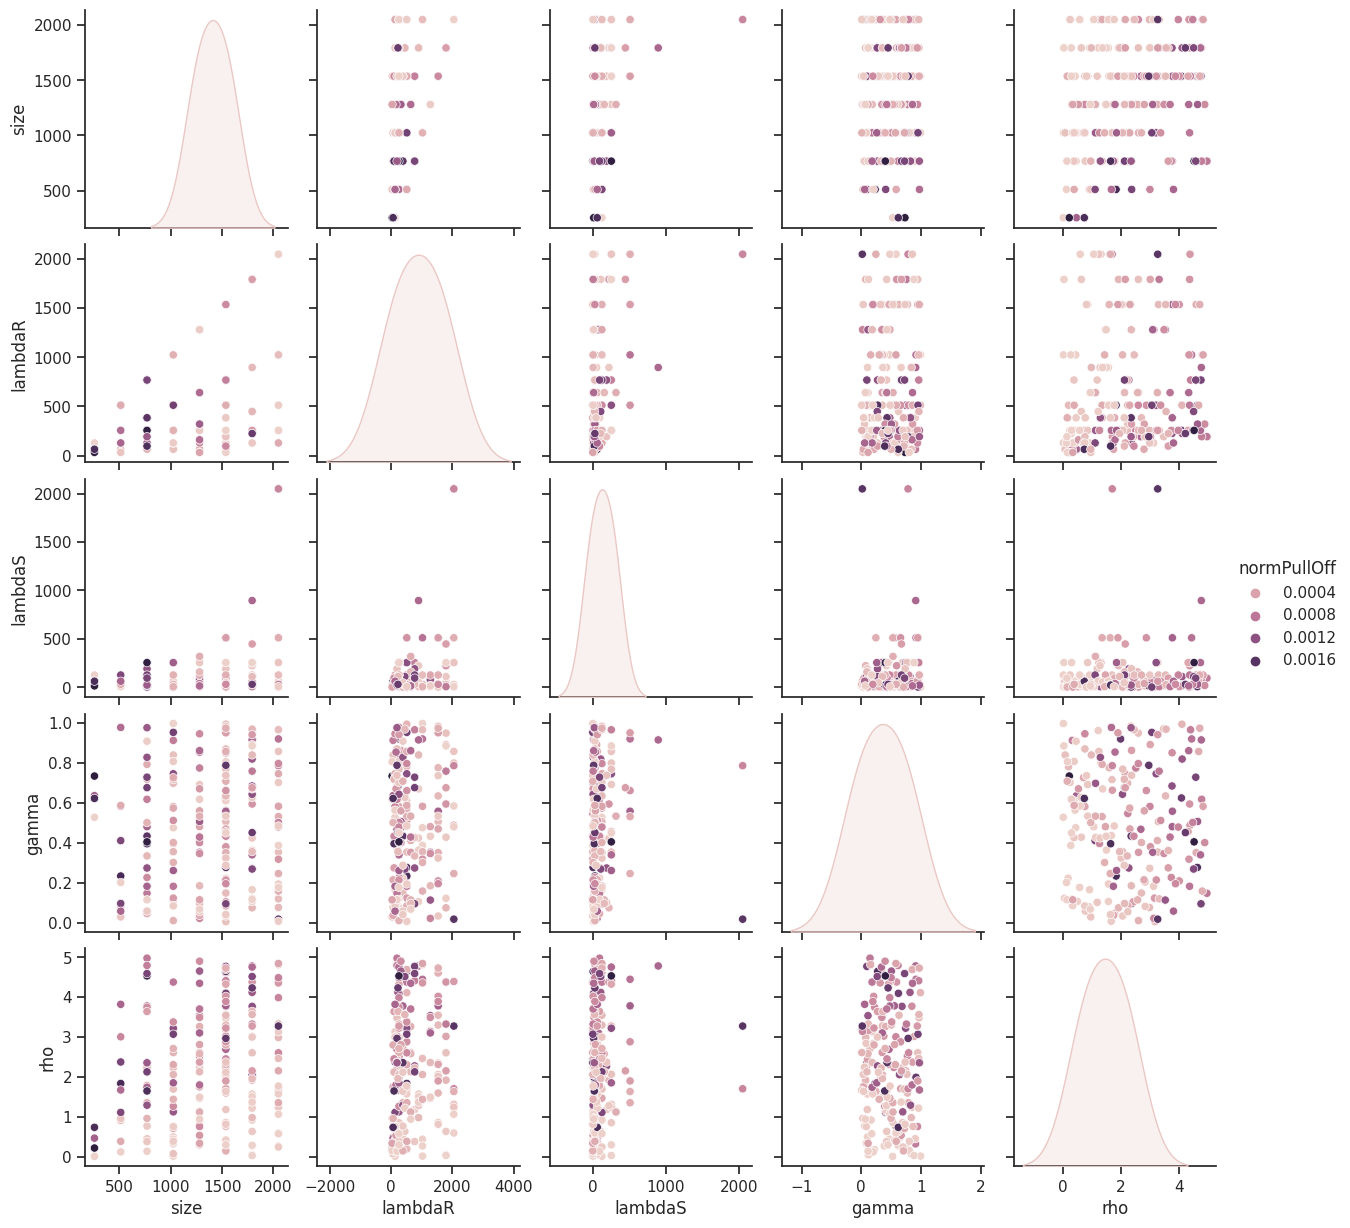

In [8]:
sns.set_theme(style="ticks")
sns.pairplot(dataset, hue='normPullOff')

In [44]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

len(train_dataset)

241

In [45]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('normPullOff')
test_labels = test_features.pop('normPullOff')

In [46]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
size,1293.809129,516.856634
lambdaR,476.813278,521.649118
lambdaS,94.323651,235.916182
gamma,0.496191,0.294882
rho,2.549278,1.376987
normPullOff,0.017656,0.049531


In [47]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[1.2938092e+03 4.7681332e+02 9.4323654e+01 4.9619135e-01 2.5492783e+00]]


In [48]:
def loss(y_true, y_pred):
  mse = keras.losses.mean_squared_error(y_true, y_pred)
  mae = keras.losses.mean_absolute_error(y_true, y_pred)
  return tf.math.sqrt(mse) + mae

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1)
  ])

  model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(1e-2))
  return model

In [49]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_24 (Dense)            (None, 128)               768       
                                                                 
 batch_normalization_20 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_21 (Bat  (None, 128)             

In [50]:
batch_size = len(train_dataset) - (int) (len(train_dataset) * 0.2)

history = dnn_model.fit(
    train_features,
    train_labels,
    batch_size=batch_size,
    validation_split=0.2,
    epochs=2000)

Epoch 1/2000


/home/marc/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


1/1 [==============================] - 8s 8s/step - loss: 3.0415 - val_loss: 0.1817
Epoch 2/2000
1/1 [==============================] - 0s 75ms/step - loss: 2.6779 - val_loss: 0.3274
Epoch 3/2000
1/1 [==============================] - 0s 64ms/step - loss: 2.5261 - val_loss: 0.3067
Epoch 4/2000
1/1 [==============================] - 0s 60ms/step - loss: 2.3932 - val_loss: 0.2558
Epoch 5/2000
1/1 [==============================] - 0s 67ms/step - loss: 2.1757 - val_loss: 0.2349
Epoch 6/2000
1/1 [==============================] - 0s 70ms/step - loss: 1.9180 - val_loss: 0.1972
Epoch 7/2000
1/1 [==============================] - 0s 63ms/step - loss: 1.8364 - val_loss: 0.1609
Epoch 8/2000
1/1 [==============================] - 0s 61ms/step - loss: 1.5490 - val_loss: 0.1527
Epoch 9/2000
1/1 [==============================] - 0s 61ms/step - loss: 1.4952 - val_loss: 0.1646
Epoch 10/2000
1/1 [==============================] - 0s 59ms/step - loss: 1.3030 - val_loss: 0.1745
Epoch 11/2000
1/1 [=====

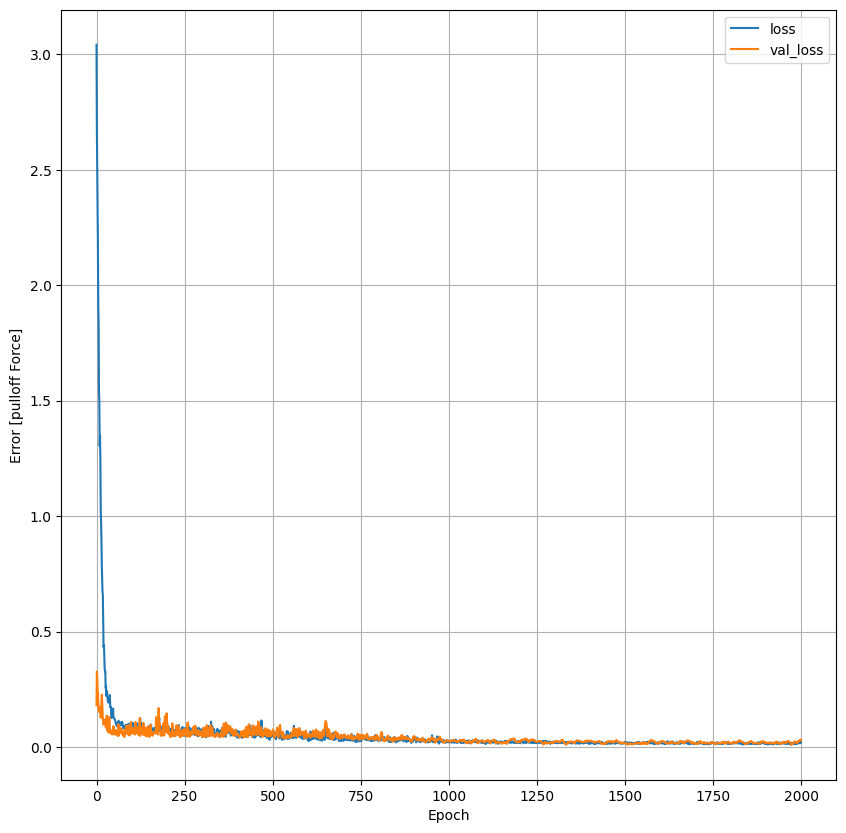

In [51]:
def plot_loss(history):
  plt.figure(figsize=(10,10))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [pulloff Force]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

2/2 [==============================] - 0s 6ms/step


[]

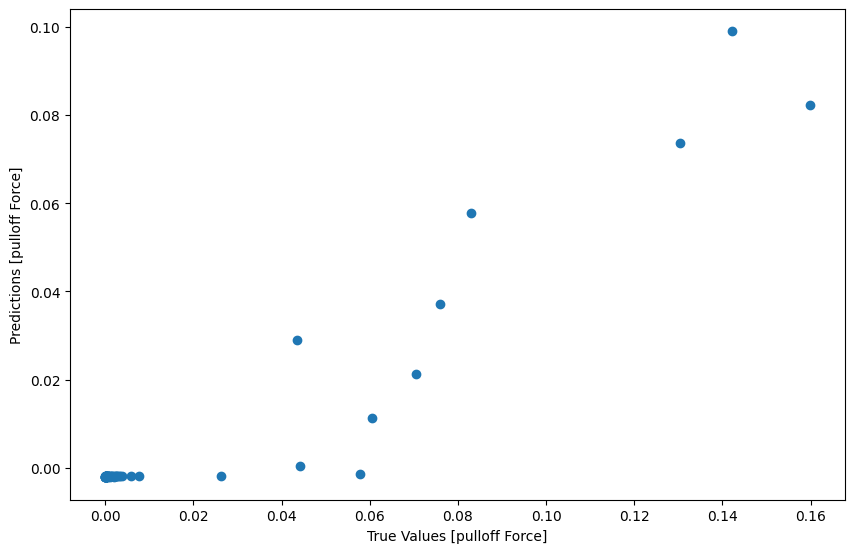

In [52]:
test_predictions = dnn_model.predict(test_features).flatten()

plt.figure(figsize=(10,10))
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [pulloff Force]')
plt.ylabel('Predictions [pulloff Force]')
plt.plot()

In [30]:
test_labels = list(test_labels)

for idx in range(len(test_labels)):
    print(test_labels[idx], test_predictions[idx])

163.09699999999998 -606.26556
5948.24 174.92213
3296.7999999999997 -163.77472
2647.82 92.56458
2723.7599999999998 1269.6567
107.585 -758.64795
127.20700000000001 -584.94226
113.721 -772.3388
1015.0999999999999 -769.6791
282.55 -407.1278
228.278 -773.13135
2111.02 -419.44403
142121.0 151214.69
57808.6 24167.125
106.49600000000001 -775.9314
7767.18 617.8262
13.0 -823.4002
26.5 -770.2168
712.094 -230.03139
61.60000000000001 -669.0413
143.323 -601.0149
82967.9 75411.38
209.678 -411.22015
558.506 -389.19623
96.4 -804.07904
535.249 -358.37988
330.109 -705.1582
75.9 -780.66876
3155.8799999999997 -287.96048
61.4 -792.4872
57.800000000000004 -784.02313
159810.0 177638.88
44209.8 56814.336
268.606 -477.49774
284.182 -802.0702
43581.4 61973.57
26308.5 4646.666
888.241 -382.1818
124.06400000000001 -442.0973
272.437 -423.9158
1886.88 -71.6478
1406.86 -140.37709
286.09700000000004 -288.24054
1486.62 -300.47308
70463.5 70847.25


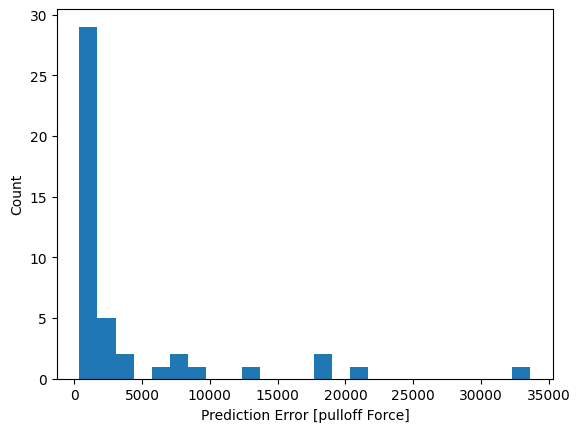

In [31]:
error = abs(test_predictions - test_labels)
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [pulloff Force]')
_ = plt.ylabel('Count')

In [32]:
test_rsme = tf.math.sqrt(keras.losses.mean_squared_error(test_labels, test_predictions))
test_rsme.numpy()

7761.303

In [15]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


INFO:tensorflow:Assets written to: dnn_model/assets
